In [58]:
from methods.stress_classes import StressTensor

my_new_stress_tensor = StressTensor(principal_stresses=[10, 20, 60], trend=30, plunge=5, rake=3)
my_new_stress_tensor.tensor

array([[12.34749468,  3.88170857,  3.78030942],
       [ 3.88170857, 18.03210343, -2.12996458],
       [ 3.78030942, -2.12996458, 59.62040189]])

[[12.5         4.33012702  0.        ]
 [ 4.33012702 17.5         0.        ]
 [ 0.          0.         60.        ]]


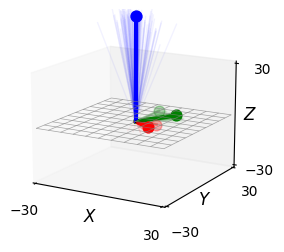

In [ ]:
from methods.stress_classes import RandomStressTensor
from methods.stress_plotting import plot_stress_tensor_with_rotated_ensemble 

# Создание ансамбля случайных тензоров
# Просто ансамбль с нормальнымираспределениями всех величин
tensor = RandomStressTensor([10, 20, 60], trend=30, plunge=0, rake=0)
ensemble_tensors, stresses, trends, plunges, rakes = tensor.generate_ensemble(
    N=200,
    stress_std_frac=0.05,
    angle_std_deg=10,
)

print(tensor) # материнский тензор

# отрисовка ансамбля тензоров
plot_stress_tensor_with_rotated_ensemble(
    tensor,
    ensemble_stresses=stresses,
    ensemble_trends=trends,
    ensemble_plunges=plunges,
    ensemble_rakes=rakes,
    max_ensemble_to_plot=100
)

# после генерации параметры ансамбля доступны в виде атрибутов обьекта tensor:
stresses = tensor.ensemble_principal_stresses # например значения главных компонент

[[22.57481595  0.          0.        ]
 [ 0.         41.28740798  0.        ]
 [ 0.          0.         60.        ]]


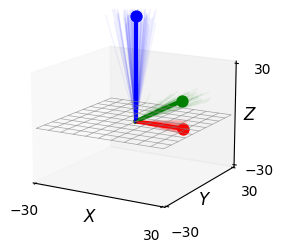

In [16]:
from methods.stress_classes import FrictionalStressTensor
from methods.stress_plotting import plot_stress_tensor_with_rotated_ensemble 

tensor = FrictionalStressTensor(s1=60, mode='zyx', ratio=0.5, pore_pressure=5, mu=0.6, cohesion=0.05, trend=0, plunge=0, rake=0)
ensemble_tensors, stresses, trends, plunges, rakes = tensor.generate_ensemble(
    N=200,
    stress_std_frac=0.05,
    angle_std_deg=5,
    random_s2 = True, # будем делать промежуточное главное напряжение случайным между максимальным и минимальным
)

print(tensor) # материнский тензор

# отрисовка ансамбля тензоров
plot_stress_tensor_with_rotated_ensemble(
    tensor,
    ensemble_stresses=stresses,
    ensemble_trends=trends,
    ensemble_plunges=plunges,
    ensemble_rakes=rakes,
    max_ensemble_to_plot=100
)

# после генерации параметры ансамбля доступны в виде атрибутов обьекта tensor:
stresses = tensor.ensemble_principal_stresses # например значения главных компонент

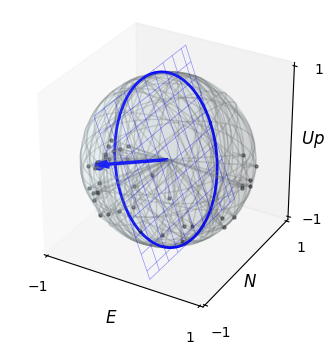

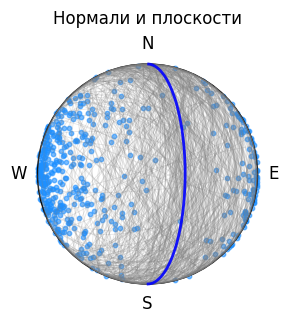

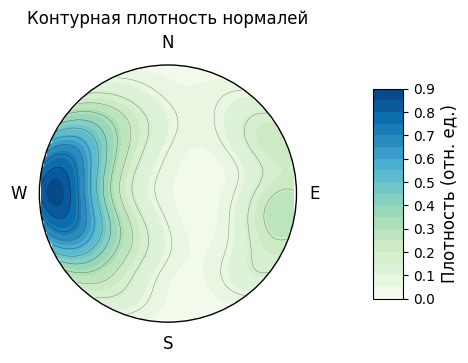

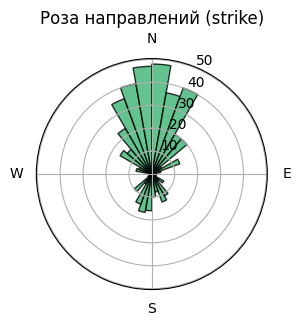

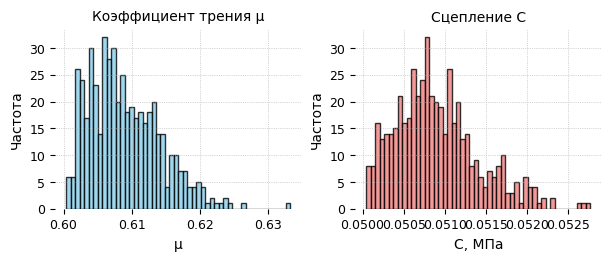

In [17]:
from methods.frac_classes import RandomFractureSeed, FisherFractureSeed
from methods.frac_plotting import plot_fracture_ensemble_on_sphere, plot_fracture_normals_and_planes, plot_fracture_density, plot_fracture_strike_rose, plot_mu_cohesion_histograms


# Создание ансамблей трещин, ориентированных согласно распределению Фишера
# коэффициенты трения и когезии могут быть одинаковы для всех трещин, 
# либо можно сделать распределенными согласно распределению Вейбулла, 
# тогда нужно передать параметры распределения, см описание класса

# создаём объект матринской трещины:
seed = FisherFractureSeed(strike=0, dip=70, mu=0.6, cohesion=0.05)

# параметры материнской трещины доступны в атрибутах объекта, например
seed.mu, seed.normal # и т.д.

# генерируем для него ансамбль из нужного количства случайно ориентированных трещин. 
# Если не задавать параметры масштаба, типа mu_weibull_scale, то все коэффициенты mu будут как у матринской трещины
# получаем массив из N векторов нормалей к плоскости трещин, и всего прочего, что может понадобится
normals, strikes, dips, mus, cohesions = seed.generate_ensemble(N=500, kappa=5, mu_weibull_scale=0.01, cohesion_weibull_scale=0.001)

# для ориентаций трещин можно воспользоваться другим классом, с нормально распределенными углами страйк и дип,
# возможно это в будущем пригодится для модели восстановления ориентации
# seed = RandomFractureSeed(strike=10, dip=90)
# normals, strikes, dips, mus, cohesions = seed.generate_ensemble(N=500, strike_std=20, dip_std=20)

# визуализация разными способами
plot_fracture_ensemble_on_sphere(normals, seed)
plot_fracture_normals_and_planes(normals, seed)
plot_fracture_density(normals)
plot_fracture_strike_rose(strikes)

# Распрелделения параметров трения и когезии для ансамбля:
plot_mu_cohesion_histograms(mus, cohesions)

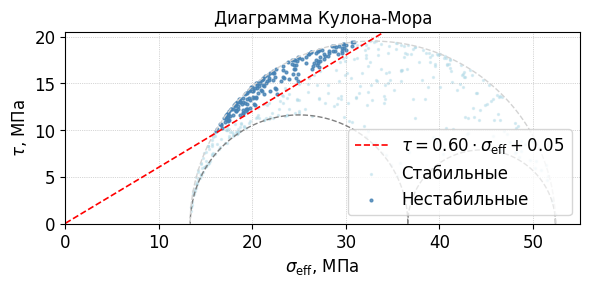

In [18]:
from methods.colomb_things import critical_pore_pressure, compute_normal_and_shear_ensemble, check_coulomb_failure
from methods.colomb_things_plotting import plot_coulomb_diagram


crit_press = critical_pore_pressure(tensor, seed) 
# Эта функция считает, какое должно быть поровое давление для материнского тензора и сида, 
# чтобы большой круг Мора коснулся критерия Кулона. То есть это нужный сдвиг круга вдоль оси сигма н до точки касания с прямой
# Ответ в тех же единицах, что и стресс - в МПа
# если tensor - объект класса FrictionalStressTensor, то это давление, очевидно, будет такое же, как было задано при его инициализации

# Теперь можно считать, какие трещины критически напряжены, для этого есть две функции:

# Нормальные и касательные напряжения. Считается сразу для всего бэтча из тензоров.
# Каждый тензор из ансамбля пересчитывается в нормальные и касательные напряжения для каждой нормали.
sigma_n, tau = compute_normal_and_shear_ensemble(ensemble_tensors, normals)

# Чекаем, для каких трещин выполнился критерий Кулона, также сразу для всех тензоров. 
# В качестве порового давления подставляем каке то, в даннлм случае критическое + 5 МПа.
# mu и cohesion можно передать единичные значения либо вектора, если они разные для разных трещин
failures = check_coulomb_failure(sigma_n, tau, mus, cohesions, pore_pressure=crit_press+5)

# можно визуализировать всю красоту в виде диграммы Кулона
idx=42 # номер какого то тензора из батча тензоров напряжений

# для него:
sigma_n = sigma_n[idx] # нормальные напряжения для всех трещин из ансамбля
tau = tau[idx] # касательные напряжения для всех трещин из ансамбля
mu = seed.mu # коэффициенты трения и когезии для отрисовки прямой критерия
cohesion = seed.cohesion 
principal_stresses = stresses[idx] # главные компоненты тензора напряжений для отрисовки кругов Мора
failures=failures[idx] # метки выполненности критерия Кулона для трещин из ансамбля, чтобы точки по разному раскрасить, если не передавать тогда сами посчитаются

plot_coulomb_diagram(sigma_n, tau, mu, cohesion, pore_pressure=crit_press+5, principal_stresses=principal_stresses, failures=failures)

### Моделирование микросейсмичности в процессе закачки жидкости

In [7]:
# Импорты всего
import numpy as np
from types import SimpleNamespace
from methods.frac_classes import FisherFractureSeed
from methods.frac_plotting import plot_fracture_ensemble_on_sphere, plot_fracture_normals_and_planes, plot_fracture_density, plot_fracture_strike_rose, plot_mu_cohesion_histograms
from methods.stress_classes import FrictionalStressTensor
from methods.stress_plotting import plot_stress_tensor_with_rotated_ensemble 
from methods.colomb_things import compute_normal_and_shear_ensemble
from methods.events import simulate_microseismicity_over_time, compute_normalized_event_curve
from methods.events_plotting import plot_events_and_pressure_vs_time, plot_events_vs_pressure
from methods.colomb_things_plotting import plot_coulomb_diagram

In [30]:
# На основе всго, что было выше, можно смоделировать микросейсмичность, возникающую в ходе роста порового давления.

# Шаг 0, задаём нужные параметры моделирования
ro_s = 2300 # плотность породы, kg/m3
ro_f = 1000 # плотность флюида
poisson = 0.3 
depth = 2000 # m 
sv = ro_s * 9.81 * depth * 1e-6  # вертикальное напряжение, MPa 
pore_press = ro_f * 9.81 * depth * 1e-6  # поровое давление, MPa

# Кривая изменения порового давления (линейная)
# от начального давления до + 10 МПа
steps = 1000 
delta_P = 10 # MPa
pore_pressure_vs_time = np.linspace(pore_press, pore_press + delta_P, steps)
time = np.linspace(0, steps*3600, steps) # время, steps часов

# Можно сделать объект с параметрами моделирования, просто для удобства, чтобы были все в одном месте, и не надо было собирать по всему коду, 
# если понадобится что то из этого варьировать
params = SimpleNamespace(
    # для тензоров
    s1 = sv,
    pore_pressure = pore_press,

    # для трещин
    mu = 0.6,
    cohesion = 0.05,
    frac_dip = 70,
    kappa = 5,
)

# Шаг 1: Создаём объект материнского тензора напряжений
tensor = FrictionalStressTensor(s1=params.s1, mode='zyx', ratio=0.5, 
                                pore_pressure=params.pore_pressure, 
                                mu=params.mu, cohesion=params.cohesion, 
                                trend=0, plunge=0, rake=0)

# семплируем бэтч случайных тензоров
tensors_batch, principal_stresses, _, _, _ = tensor.generate_ensemble(
    N=50,
    stress_std_frac=0.05, # 5% стд для s1
    angle_std_deg=(5, 0, 0), # 5 градусов вариаций по ориентации в горизонтальной плоскости, остальные одинаковые
    random_s2 = True, # будем делать промежуточное главное напряжение случайным между максимальным и минимальным
)

# Шаг 3: Создаём объект материнской трещины и сэмплируем ансамбль терщин
seed = FisherFractureSeed(strike=0, dip=params.frac_dip, mu=params.mu, cohesion=params.cohesion)
normals, _, _, _, _ = seed.generate_ensemble(N=10000, kappa=params.kappa)

# Шаг 4: Расчёт нормальных и касательных напряжений
sigma_n, tau = compute_normal_and_shear_ensemble(tensors_batch, normals) # (N, M)

# Шаг 5: Расчёт событий. В качестве параметров mu и cohesion можно передать как единичные значения, так и вектора значений, если они разные для разных трещин
events_vs_time = simulate_microseismicity_over_time(sigma_n, tau, params.mu, params.cohesion, pore_pressure_vs_time)
# получаем количество событий на каждом шаге изменения давления для бетча тензоров

# Шаг 6: Можно теперь перенормировать события в распредлеления по времени, чтобы уйти от конкретного числа событий
# распределдние количества событий можно строить по минутам, часам или дням, 
# для этого надо указаь time_unit='m' (или 'h' или 'd', подразумевая, что вектор времени указан в секундах) 
# функция возвращает вектор времен - центры соотвествующих бинов
# binned_events - нормированное количество событий, в сумме будет 1 для каждото тензора из бэтчя 
times, binned_events = compute_normalized_event_curve(time, events_vs_time, time_unit='h')

Проверка критерия Кулона-Мора по времени...


Временные шаги:   0%|          | 0/1000 [00:00<?, ?it/s]

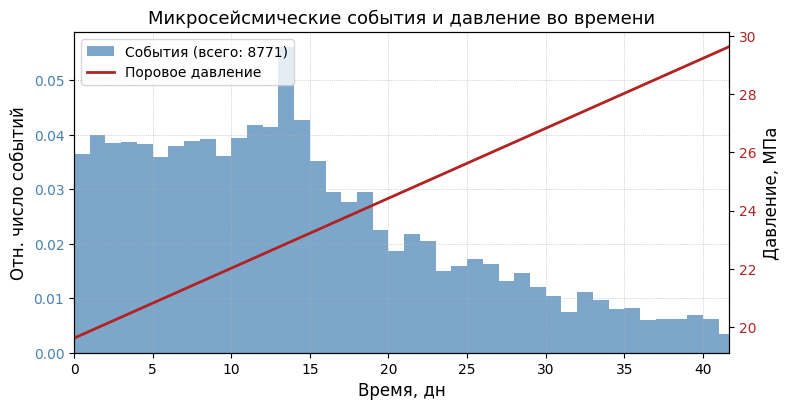

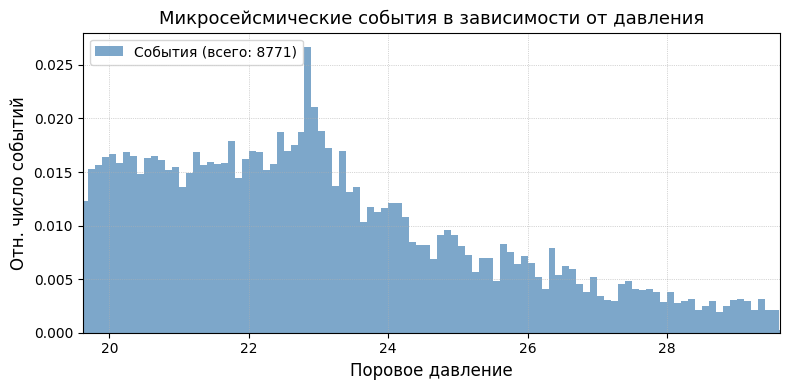

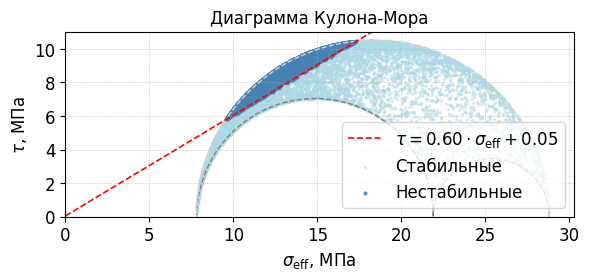

In [31]:
# Шаг 7: Рисуем графики, любуемся
idx = 42 # какой то тензор
plot_events_and_pressure_vs_time(time, events_vs_time[idx], pore_pressure_vs_time, time_unit='d') 
plot_events_vs_pressure(pore_pressure_vs_time, events_vs_time[idx])

# Если что, пики на некоторых графиках соответствуют касанию нижнего круга, нужно как то это проинтерпретировать
time_idx = 200 
plot_coulomb_diagram(sigma_n[idx], tau[idx], 
                     params.mu, params.cohesion, 
                     pore_pressure=pore_pressure_vs_time[time_idx], 
                     principal_stresses=principal_stresses[idx])